In [85]:
# Basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dataset manipulation/vectorization libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from keras.layers import Input, Dense, Lambda, Layer
from keras import backend as K
from keras import metrics

# Dimensionality Reduction algorithms
from sklearn.decomposition import TruncatedSVD

# Evaluation libraries
from sklearn.metrics import classification_report

import time


In [4]:
from transformers import DistilBertConfig,RobertaConfig
from transformers import DistilBertTokenizer,DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification,DistilBertModel
from transformers import TFDistilBertForSequenceClassification,TFDistilBertModel
from transformers import RobertaTokenizer, RobertaModel
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import os
from tensorflow.keras.layers import Dense,Dropout, Input
from tensorflow.keras import regularizers
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

2022-12-21 10:43:31.616416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-21 10:43:31.616494: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to /home/titon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
train= pd.read_csv('emotion_train.txt',delimiter=';',header=None,names=['sentence','label'])
test= pd.read_csv ('emotion_test.txt',delimiter=';',header=None,names=['sentence','label'])
valid= pd.read_csv('emotion_val.txt',delimiter=';',header=None, names=['sentence','label'])

In [6]:
df=pd.concat([train,test,valid])

In [7]:
label_count=df['label'].value_counts()
label=label_count.index
print(label)

Index(['joy', 'sadness', 'anger', 'fear', 'love', 'surprise'], dtype='object')


In [8]:
df['encoded_labels'] = df['label'].astype('category').cat.codes

In [9]:
df.head()

,sentence,label,encoded_labels
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,0


# Vectorization du texte avec TFIDF + Construction du Training/Test Set 

In [10]:
X = df['sentence']
y = df['encoded_labels']

tfidf=TfidfVectorizer()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

t0 = time.time ()
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

t1 = time.time()

print("Durée de la vectorization:", t1 - t0)
print("Dimensionalité du Training set: ", X_train_vec.shape)
print("Dimensionalité du Test set: ", X_test_vec.shape)

Durée de la vectorization: 0.3995063304901123
Dimensionalité du Training set:  (16000, 15287)
Dimensionalité du Test set:  (4000, 15287)


Nombre de composants = 5 et variance expliquée = 0.02653377185639032
Nombre de composants = 10 et variance expliquée = 0.047508933346076435
Nombre de composants = 20 et variance expliquée = 0.0809392515442557
Nombre de composants = 50 et variance expliquée = 0.15357949576766372
Nombre de composants = 100 et variance expliquée = 0.22958830210567605
Nombre de composants = 150 et variance expliquée = 0.2831933391184601
Nombre de composants = 200 et variance expliquée = 0.3271211591769783
Nombre de composants = 500 et variance expliquée = 0.5071187946438152
Nombre de composants = 700 et variance expliquée = 0.5858056184167884
Nombre de composants = 800 et variance expliquée = 0.6158244648729111
Nombre de composants = 900 et variance expliquée = 0.6411746698215798
Nombre de composants = 1000 et variance expliquée = 0.6630507863053585
Nombre de composants = 1500 et variance expliquée = 0.7422162834719184
Nombre de composants = 2000 et variance expliquée = 0.7936836539467639
Nombre de composa

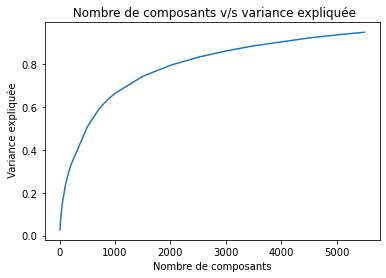

In [21]:
# Programme pour trouver le nbre de composants optimal pour Truncated SVD 

n_comp = [5,10,20,50,100,150,200,500,700,800,900,1000,1500,2000,2500,3000,3500,4500,5000,5500] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(X_train_vec)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Nombre de composants = %r et variance expliquée = %r"%(x,svd.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Nombre de composants')
plt.ylabel(" Variance expliquée")
plt.title(" Nombre de composants vs variance expliquée")
plt.show()

Avec k= 2000 composants, nous obtenons une variance expliquée > 80%,
donc avec 2000 mots on peut expliquer 95% de nos données

# Réduction de dimension pour X_train de (16000,15287) ---> à (16000,2000)

# Réduction de dimension pour X_test de (4000,15287) ---> à (4000,2000)

In [24]:
svd = TruncatedSVD(n_components= 2000)
X_train_red = svd.fit_transform(X_train_vec)
X_test_red = svd.transform(X_test_vec)


In [26]:
X_train_red.shape, X_test_red.shape

((16000, 5500), (4000, 5500))

In [28]:

scatter_x = X_train_red[:, 0] # premier composant
scatter_y = X_train_red[:, 1] # Deuxième composant

In [31]:
pred_label_svd= KMeans(6, random_state=42).fit(X_test_red).labels_

In [32]:
clustering_model = KMeans(n_clusters=6,random_state=0)
clustering_model.fit(X_test_red)
cluster_assignment = clustering_model.labels_

In [33]:
clusters = clustering_model.predict(X_test_red)

# Vectorization du texte avec DistilBert

In [111]:
model_type = "roberta-base"

tokenizer = RobertaTokenizer.from_pretrained(model_type)
model     = RobertaModel.from_pretrained(model_type)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [112]:
# Méthode de réduction de dimension proposée dans le papier:
# "Whitening Sentence Representations for Better Semantics and Faster Retrieval"


def Dim_reduction(sentences, tokenizer, model):
    '''
        This method will accept array of sentences, roberta tokenizer & model
        next it will call methods for dimention reduction
    '''

    vecs = []
    

    for sentence in sentences:
            inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True,  max_length=64)
            inputs['input_ids'] = inputs['input_ids']
            inputs['attention_mask'] = inputs['attention_mask']

            hidden_states = model(**inputs, return_dict=True, output_hidden_states=True).hidden_states

            #Averaging the first & last hidden states
            output_hidden_state = (hidden_states[-1] + hidden_states[1]).mean(dim=1)

            vec = output_hidden_state.detach().numpy()[0]

            vecs.append(vec)

    #Finding Kernal
    kernel, bias = compute_kernel_bias([vecs])
    kernel = kernel[:, :128]
    #If you want to reduce it to 128 dim
    #kernel = kernel[:, :128]
    embeddings = []
    embeddings = np.vstack(vecs)

    #Sentence embeddings can be converted into an identity matrix
    #by utilizing the transformation matrix
    embeddings = transform_and_normalize(embeddings, 
                kernel=kernel,
                bias=bias
            )

    return embeddings

In [113]:

import numpy as np

def transform_and_normalize(vecs, kernel, bias):
    """
        Applying transformation then standardize
    """
    if not (kernel is None or bias is None):
        vecs = (vecs + bias).dot(kernel)
    return normalize(vecs)
    
def normalize(vecs):
    """
        Standardization
    """
    return vecs / (vecs**2).sum(axis=1, keepdims=True)**0.5
    
def compute_kernel_bias(vecs):
    """
    Calculate Kernal & Bias for the final transformation - y = (x + bias).dot(kernel)
    """
    vecs = np.concatenate(vecs, axis=0)
    mu = vecs.mean(axis=0, keepdims=True)
    cov = np.cov(vecs.T)
    u, s, vh = np.linalg.svd(cov)
    W = np.dot(u, np.diag(s**0.5))
    W = np.linalg.inv(W.T)
    return W, -mu

In [57]:
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')


In [102]:
Corpus_train=X_train.tolist()
Corpus_test=X_test.tolist()

In [103]:
X_train_vec1 = embedder.encode(Corpus_train)
X_test_vec1 = embedder.encode(Corpus_test)

In [61]:
X_train_vec1.shape

(16000, 768)

In [104]:
X_test_vec1.shape

(4000, 768)

Nombre de composants = 5 et variance expliquée = 0.28865385
Nombre de composants = 10 et variance expliquée = 0.4272735
Nombre de composants = 20 et variance expliquée = 0.57784337
Nombre de composants = 32 et variance expliquée = 0.6790074
Nombre de composants = 64 et variance expliquée = 0.80308783
Nombre de composants = 128 et variance expliquée = 0.8895705
Nombre de composants = 150 et variance expliquée = 0.90524274
Nombre de composants = 200 et variance expliquée = 0.9304477
Nombre de composants = 256 et variance expliquée = 0.94922316
Nombre de composants = 300 et variance expliquée = 0.9600026
Nombre de composants = 400 et variance expliquée = 0.97712433
Nombre de composants = 450 et variance expliquée = 0.9831275
Nombre de composants = 512 et variance expliquée = 0.9889401


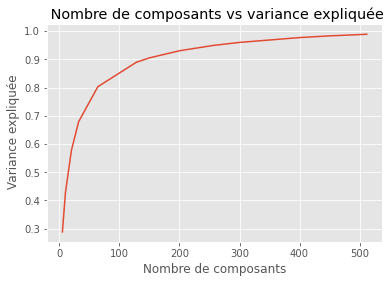

In [65]:
# Programme pour trouver le nbre de composants optimal qui explique la variabilité des données

n_comp = [5,10,20,32,64,128,150,200,256,300,400,450,512,] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(X_train_vec1)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Nombre de composants = %r et variance expliquée = %r"%(x,svd.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Nombre de composants')
plt.ylabel(" Variance expliquée")
plt.title(" Nombre de composants vs variance expliquée")
plt.show()

In [15]:
# Réduction de demension à 256
t0 = time.time ()

embeddings_256 = Dim_reduction(X_train, tokenizer, model)
embeddings_256 = Dim_reduction(X_test, tokenizer, model)

t1 = time.time ()

print("Durée de la vectorization:", t1 - t0)

Durée de la vectorization: 830.9769399166107


In [18]:
t0 = time.time ()

embeddings_256 = Dim_reduction(X_test, tokenizer, model)

t1 = time.time ()

print("Durée de la vectorization:", t1 - t0)

Durée de la vectorization: 203.75255608558655


# Représentation des clusters après réduction de dimension à 256

In [21]:
clustering_model = KMeans(n_clusters=6,random_state=0)
clustering_model.fit(embeddings_256)
cluster_assignment = clustering_model.labels_

In [22]:
clusters = clustering_model.predict(embeddings_256)

In [23]:
from sklearn.decomposition import PCA

# Eatpe 1: Faire correspondre chaque document à son cluster 
#clusters = model.predict(X_train_vc)
#clustering_model.predict(corpus_embeddings)


# Entraînement de L ACP sur la version dense de tf-idf 
pca = PCA(n_components=256)
two_dim = pca.fit_transform(embeddings_256)

scatter_x = two_dim[:, 0] # premier composant
scatter_y = two_dim[:, 1] # Deuxième composant

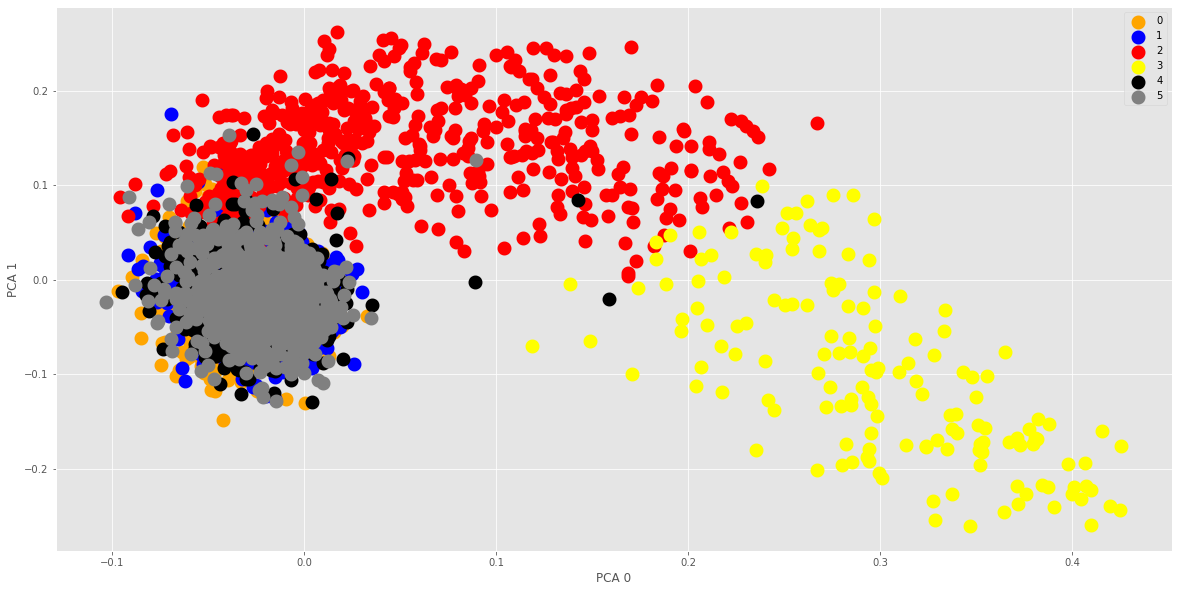

In [24]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig, ax = plt.subplots()
fig.set_size_inches(20,10)

# couleur de clusters 
cmap = {0: 'orange', 1: 'blue', 2: 'red', 3: 'yellow', 4: 'black',5:'grey'}

# group by clusters and scatter plot every cluster
# with a colour and a label
for group in np.unique(clusters):
    ix = np.where(clusters == group)
    ax.scatter(scatter_x[ix], scatter_y[ix], c=cmap[group], label=group, s=80, linewidths=5, zorder=10)

ax.legend()
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.show()

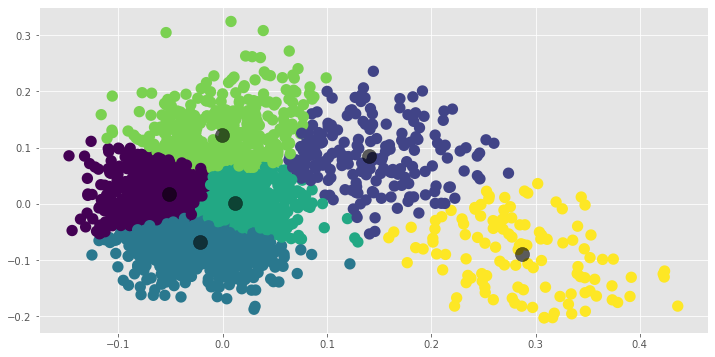

In [25]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(embeddings_256)
kmeans = KMeans(n_clusters=6, max_iter=600, tol=0.000001, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.figure(figsize=(12, 6))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=40, cmap='viridis', linewidths=5)

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=200, alpha=0.6);

In [74]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [75]:

from rpy2.robjects.packages import importr
utils = importr('utils')

In [50]:
embeddings.shape

((16000, 256), (16000,))

In [51]:
embeddings

array([[-0.09623304, -0.02450967, -0.10443514, ...,  0.01544522,
         0.00346969,  0.03417911],
       [-0.04833374, -0.02014373,  0.05451165, ...,  0.02481632,
        -0.00101621,  0.06111599],
       [ 0.06593787,  0.11075106,  0.03665522, ..., -0.00744093,
         0.02556196,  0.00119535],
       ...,
       [-0.00191851, -0.05693836,  0.03008675, ...,  0.02935849,
         0.10876126,  0.04369636],
       [-0.00542717, -0.03554896,  0.00840348, ...,  0.00517946,
         0.07483   ,  0.00916518],
       [ 0.0424513 , -0.02489033,  0.07269189, ..., -0.06865445,
        -0.00470606,  0.07724871]])

In [114]:
# Réduction de dimension à 128
t0 = time.time ()

embeddings_128 = Dim_reduction(X_train, tokenizer, model)

t1 = time.time ()

print("Durée de la vectorization:", t1 - t0)

Durée de la vectorization: 796.8669991493225


In [116]:
# Réduction de dimension à 128
t0 = time.time ()

embeddings_test_128 = Dim_reduction(X_test, tokenizer, model)

t1 = time.time ()

print("Durée de la vectorization:", t1 - t0)

Durée de la vectorization: 199.35304713249207


In [117]:
embeddings_test_128.shape

(4000, 128)

# Représentation des clusters après réduction de dimension à 128

In [118]:
clustering_model = KMeans(n_clusters=6,random_state=0)
clustering_model.fit(embeddings_test_128)
cluster_assignment = clustering_model.labels_
clusters = clustering_model.predict(embeddings_test_128)

In [119]:
from sklearn.decomposition import PCA

# Eatpe 1: Faire correspondre chaque document à son cluster 
#clusters = model.predict(X_train_vc)
#clustering_model.predict(corpus_embeddings)


# Entraînement de L ACP sur la version dense de tf-idf 
pca = PCA(n_components=128)
two_dim = pca.fit_transform(embeddings_test_128)

scatter_x = two_dim[:, 0] # premier composant
scatter_y = two_dim[:, 1] # Deuxième composant

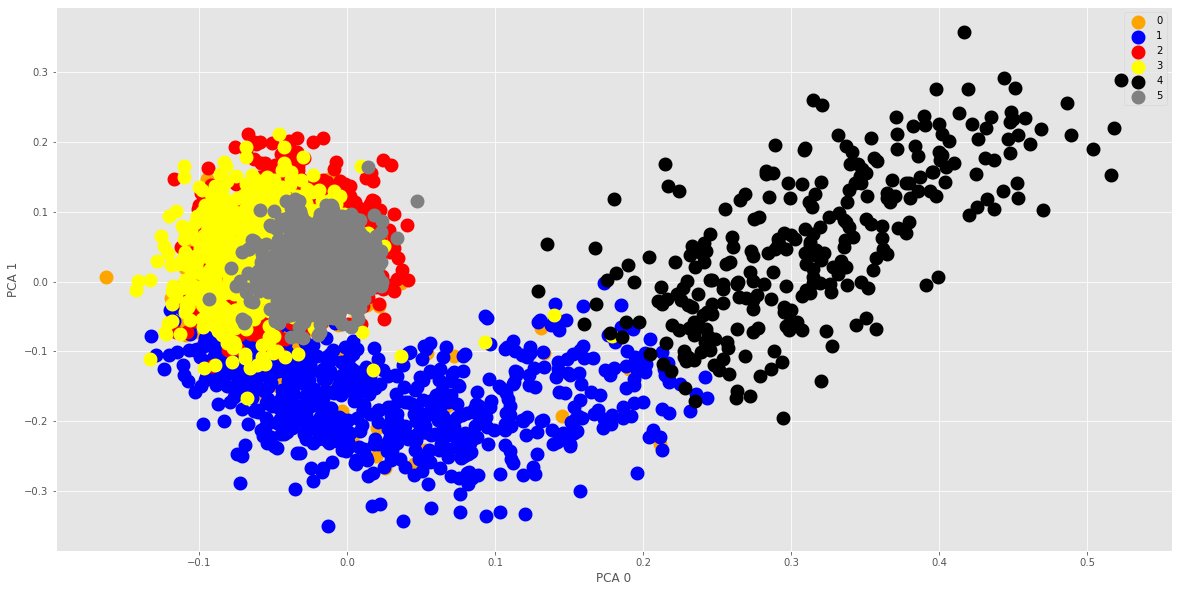

In [120]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig, ax = plt.subplots()
fig.set_size_inches(20,10)

# couleur de clusters 
cmap = {0: 'orange', 1: 'blue', 2: 'red', 3: 'yellow', 4: 'black',5:'grey'}

# group by clusters and scatter plot every cluster
# with a colour and a label
for group in np.unique(clusters):
    ix = np.where(clusters == group)
    ax.scatter(scatter_x[ix], scatter_y[ix], c=cmap[group], label=group, s=80, linewidths=5, zorder=10)

ax.legend()
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.show()

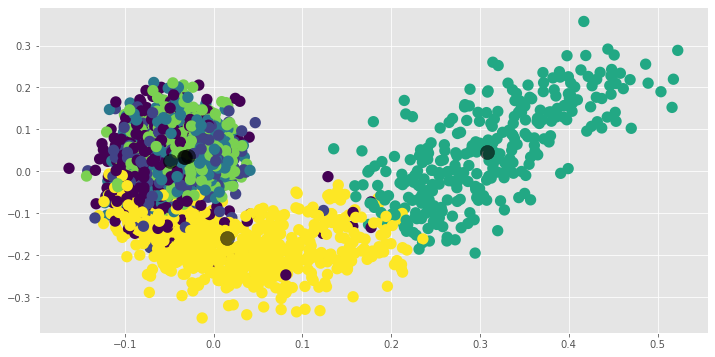

In [121]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 128)
Y_sklearn = sklearn_pca.fit_transform(embeddings_test_128)
kmeans = KMeans(n_clusters=6, max_iter=600, tol=0.000001, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.figure(figsize=(12, 6))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=40, cmap='viridis', linewidths=5)

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=200, alpha=0.6);

In [35]:
# Reduction de dimension à 64
t0 = time.time ()

embeddings_64 = Dim_reduction(X_train, tokenizer, model)

t1 = time.time ()

print("Durée de la vectorization:", t1 - t0)

Durée de la vectorization: 830.7947516441345


In [36]:
t0 = time.time ()

embeddings_64 = Dim_reduction(X_test, tokenizer, model)

t1 = time.time ()

print("Durée de la vectorization:", t1 - t0)

Durée de la vectorization: 201.41902446746826


In [37]:
embeddings_64.shape


(4000, 64)

# Représentation des clusters après réduction de dimension à 64

In [39]:
clustering_model = KMeans(n_clusters=6,random_state=0)
clustering_model.fit(embeddings_64)
cluster_assignment = clustering_model.labels_
clusters = clustering_model.predict(embeddings_64)

In [40]:
from sklearn.decomposition import PCA

# Eatpe 1: Faire correspondre chaque document à son cluster 
#clusters = model.predict(X_train_vc)
#clustering_model.predict(corpus_embeddings)


# Entraînement de L ACP sur la version dense de tf-idf 
pca = PCA(n_components=64)
two_dim = pca.fit_transform(embeddings_64)

scatter_x = two_dim[:, 0] # premier composant
scatter_y = two_dim[:, 1] # Deuxième composant

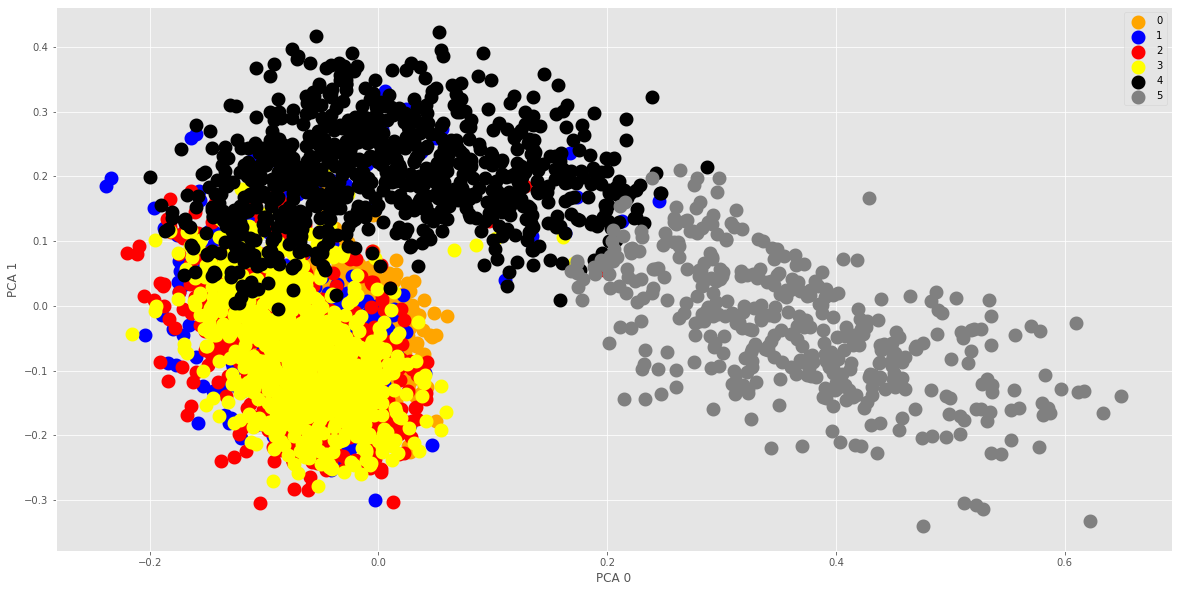

In [41]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig, ax = plt.subplots()
fig.set_size_inches(20,10)

# couleur de clusters 
cmap = {0: 'orange', 1: 'blue', 2: 'red', 3: 'yellow', 4: 'black',5:'grey'}

# group by clusters and scatter plot every cluster
# with a colour and a label
for group in np.unique(clusters):
    ix = np.where(clusters == group)
    ax.scatter(scatter_x[ix], scatter_y[ix], c=cmap[group], label=group, s=80, linewidths=5, zorder=10)

ax.legend()
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.show()

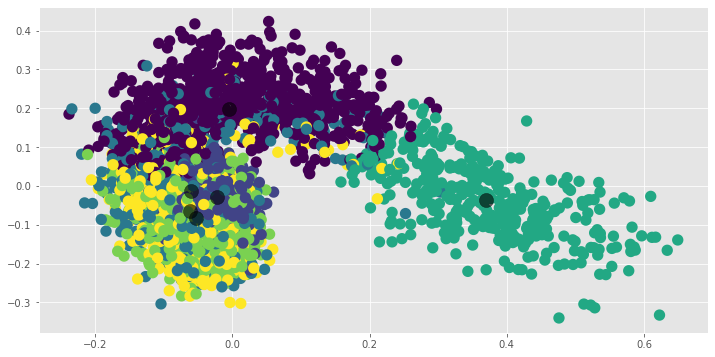

In [67]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 64)
Y_sklearn = sklearn_pca.fit_transform(embeddings_64)
kmeans = KMeans(n_clusters=6, max_iter=600, tol=0.000001, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.figure(figsize=(12, 6))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=40, cmap='viridis', linewidths=5)

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=200, alpha=0.6);

In [45]:
# Réduction de dimension à 32
t0 = time.time ()

embeddings_32 = Dim_reduction(X_train, tokenizer, model)

t1 = time.time ()

print("Durée de la vectorization:", t1 - t0,"secondes")

Durée de la vectorization: 835.254362821579 secondes


In [46]:
t0 = time.time ()

embeddings_32 = Dim_reduction(X_test, tokenizer, model)

t1 = time.time ()

print("Durée de la vectorization:", t1 - t0,"secondes")

Durée de la vectorization: 202.68819189071655 secondes


# Représentation des clusters après réduction de dimension à 32

In [47]:
clustering_model = KMeans(n_clusters=6,random_state=0)
clustering_model.fit(embeddings_32)
cluster_assignment = clustering_model.labels_
clusters = clustering_model.predict(embeddings_32)

In [48]:
from sklearn.decomposition import PCA

# Eatpe 1: Faire correspondre chaque document à son cluster 
#clusters = model.predict(X_train_vc)
#clustering_model.predict(corpus_embeddings)


# Entraînement de L ACP sur la version dense de tf-idf 
pca = PCA(n_components=32)
two_dim = pca.fit_transform(embeddings_32)

scatter_x = two_dim[:, 0] # premier composant
scatter_y = two_dim[:, 1] # Deuxième composant

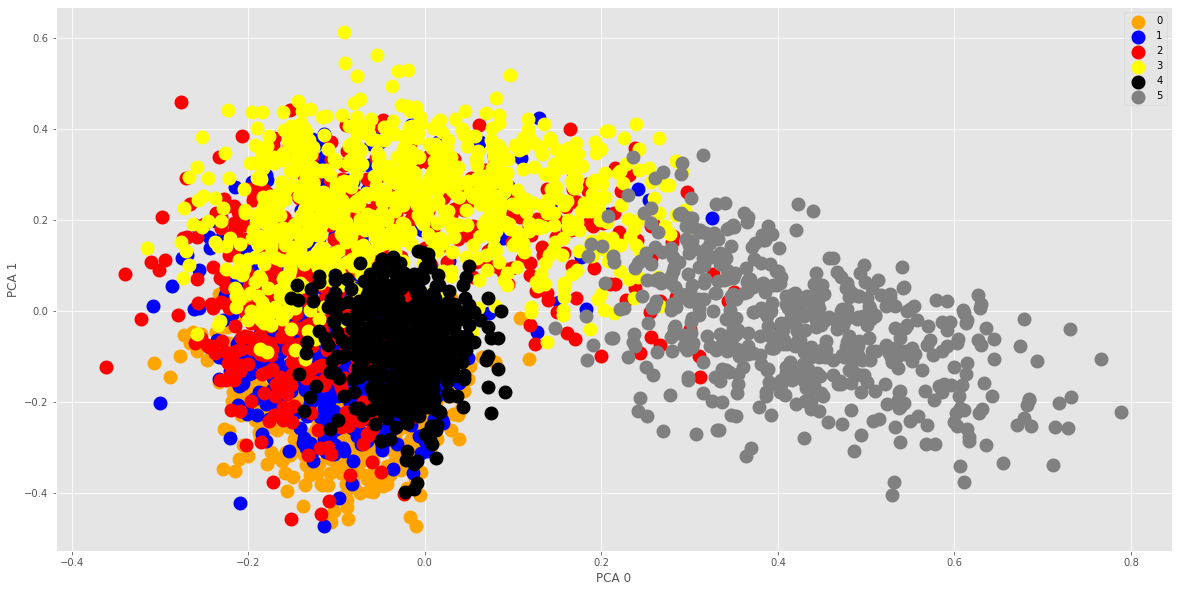

In [49]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig, ax = plt.subplots()
fig.set_size_inches(20,10)

# couleur de clusters 
cmap = {0: 'orange', 1: 'blue', 2: 'red', 3: 'yellow', 4: 'black',5:'grey'}

# group by clusters and scatter plot every cluster
# with a colour and a label
for group in np.unique(clusters):
    ix = np.where(clusters == group)
    ax.scatter(scatter_x[ix], scatter_y[ix], c=cmap[group], label=group, s=80, linewidths=5, zorder=10)

ax.legend()
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.show()

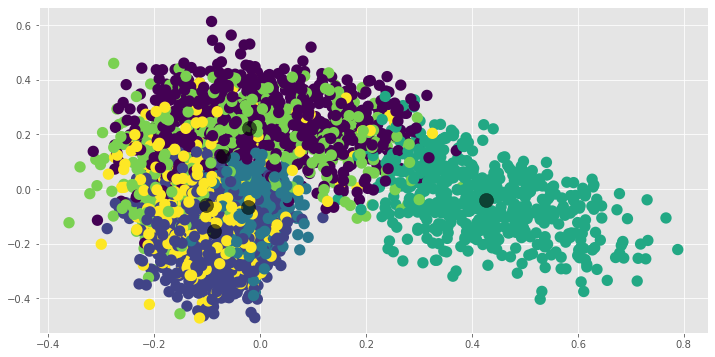

In [146]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 32)
Y_sklearn = sklearn_pca.fit_transform(embeddings_32)
kmeans = KMeans(n_clusters=6, max_iter=600, tol=0.000001, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.figure(figsize=(12, 6))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=40, cmap='viridis', linewidths=5)

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=200, alpha=0.6);

# Réduction de dimension avec l'auto encodeur


In [ ]:
# Version 1

from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 1500

# this is our input placeholder
input = Input(shape=(n,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(n, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input, decoded)

# this model maps an input to its encoded representation
encoder = Model(input, encoded)


encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [144]:
# Version 2

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense

input_dim = 768 # Dimension du modèle pré-entraîné Ditilbert => 768
latent_vec_dim = 128 # Dimension souhaitée pour notre espace latent

input_layer = Input(shape=(input_dim,))

# Define the autoencoder architecture
# Construction de l'encoder
enc_layer_1 = Dense(512, activation='relu')(input_layer)
enc_layer_2 = Dense(256, activation='relu')(enc_layer_1)
#enc_layer_3 = Dense(128, activation='relu')(enc_layer_2)
latent_layer_3 = Dense(latent_vec_dim, activation='relu',name="espace_latent")(enc_layer_2)
encoder = latent_layer_3

# Construction du decoder
dec_layer_1 = Dense(256, activation='relu')(encoder)
dec_layer_2 = Dense(512, activation='relu')(dec_layer_1)
#dec_layer_3 = Dense(512, activation='relu')(dec_layer_2)
dec_layer_3 = Dense(input_dim, activation='relu')(dec_layer_2)
decoder = dec_layer_3

# Connection de l'encodeur et décodeur 
autoencoder = Model(input_layer, decoder, name="Autoencoder")
# Latent representation (Optional)
latent_model = Model(input_layer, encoder)

# Get summary
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_85 (Dense)            (None, 512)               393728    
                                                                 
 dense_86 (Dense)            (None, 256)               131328    
                                                                 
 espace_latent (Dense)       (None, 128)               32896     
                                                                 
 dense_87 (Dense)            (None, 256)               33024     
                                                                 
 dense_88 (Dense)            (None, 512)               131584    
                                                                 
 dense_89 (Dense)            (None, 768)               

In [140]:
# Compilation du modèle
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

In [136]:
# Pour la réduction de dimesion
encoder = Model(input_layer, latent_layer_3 )

X_test_reduced = encoder.predict(X_test_vec1)

In [137]:
X_test_reduced.shape

(4000, 128)

In [141]:
# Entraînement de l'autoencodeur
history = autoencoder.fit(X_train_vec1,X_train_vec1, epochs=4, batch_size=128,
                          shuffle=True,validation_split=0.25 )

Epoch 1/4


2022-12-22 15:24:21.669648: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 36864000 exceeds 10% of free system memory.
2022-12-22 15:24:21.679155: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 36864000 exceeds 10% of free system memory.


94/94 [==============================] - 3s 19ms/step - loss: -1.4712 - val_loss: -1.5994
Epoch 2/4
94/94 [==============================] - 1s 16ms/step - loss: -1.6471 - val_loss: -1.6018
Epoch 3/4
94/94 [==============================] - 1s 16ms/step - loss: -1.5161 - val_loss: -1.6058
Epoch 4/4
94/94 [==============================] - 1s 15ms/step - loss: -1.6397 - val_loss: -1.6273


No handles with labels found to put in legend.


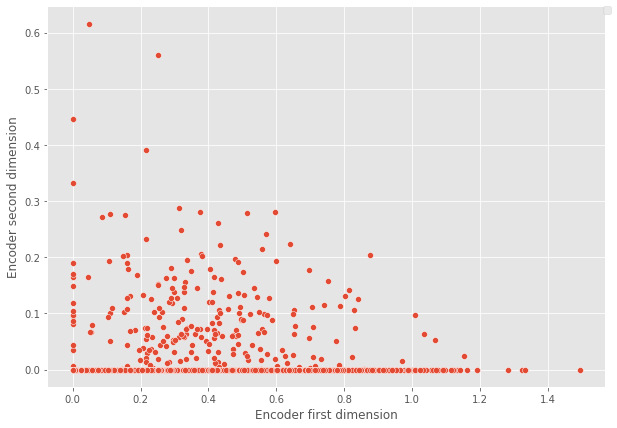

In [145]:
# Projection de l'espace latent en dimension 64
# Latent representation 
latent_model = Model(input_layer, encoder)

latent_representation = latent_model.predict(X_test_vec1,)

import seaborn as sns

plt.figure(figsize=(10, 7))

sns.scatterplot(x=latent_representation[:,0],
                y=latent_representation[:,1], palette='tab10')

plt.xlabel("Encoder first dimension")
plt.ylabel("Encoder second dimension")

plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)

# Réduction de dimension du modèle pré-entrainé BERT avec VAE

In [122]:
batch_size = 128
original_dim = 768 # --> Dimensionnalité du modèle Bert
intermediate_dim = 256
latent_dim = 128
epochs = 5
epsilon_std = 1.0


x = Input(shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim,name='Z_mean')(h)
z_log_var = Dense(latent_dim,name='Z_log_var')(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='softmax')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# placeholder loss
def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # we don't use this output, but it has to have the correct shape:
        return K.ones_like(x)

loss_layer = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, [loss_layer])
vae.compile(optimizer='adam', loss=[zero_loss])


In [123]:
vae.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 128, 768)]   0           []                               
                                                                                                  
 dense_67 (Dense)               (None, 128, 256)     196864      ['input_17[0][0]']               
                                                                                                  
 Z_mean (Dense)                 (None, 128, 128)     32896       ['dense_67[0][0]']               
                                                                                                  
 Z_log_var (Dense)              (None, 128, 128)     32896       ['dense_67[0][0]']               
                                                                                           

In [ ]:
#train
vae.fit(X_train_vec1,X_train_vec1,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.25)

In [ ]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)